## Detect Jupyter, compile scripts and turn demo on

In [1]:
def isnotebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

In [2]:

notebook = isnotebook()   ########## OVERRIDE HERE IF NOT WORKING !!!

from sys import stdin

if notebook:
    
    # Compile script/modules from notebooks
    !jupyter nbconvert --to script union_find.ipynb kruskal.ipynb prim.ipynb connected_components.ipynb
    
    !jupyter nbconvert --to script clustering.ipynb
    
    testFile = open("data.txt")
    old_stdin, stdin = stdin, testFile
    
    import sklearn.metrics as metrics
    import matplotlib.pyplot as plt
    %matplotlib inline

[NbConvertApp] Converting notebook union_find.ipynb to script
[NbConvertApp] Writing 1665 bytes to union_find.py
[NbConvertApp] Converting notebook kruskal.ipynb to script
[NbConvertApp] Writing 1392 bytes to kruskal.py
[NbConvertApp] Converting notebook prim.ipynb to script
[NbConvertApp] Writing 1688 bytes to prim.py
[NbConvertApp] Converting notebook connected_components.ipynb to script
[NbConvertApp] Writing 603 bytes to connected_components.py
[NbConvertApp] Converting notebook clustering.ipynb to script
[NbConvertApp] Writing 6162 bytes to clustering.py


In [3]:
import sys
import numpy as np

In [4]:
# implemented modules
from kruskal import Kruskall
from prim import Prim
from connected_components import find_components

## Minor functions

In [5]:
def edges_to_adj(edge_list, nnodes):
    """undirected edge list"""
    adj=[ [] for i in range(nnodes) ]
    for e in edge_list:
        adj[e[1]].append(e)
        adj[e[2]].append((e[0], e[2], e[1]))
    return adj

def color_map(i):
    colors = ['gray','g','b','c','m','y','k']
    return colors[i] if i<len(colors) else 'k'

def draw_edges(edges, pv, color):
    for e in edges:
        n1, n2 = e[1:]  
        plt.plot(*pv[[n1,n2]].T, color)

def draw_points(pv, partition):
    for i in range(len(pv)):
        plt.plot(*pv[i].T, 'o', color=color_map(partition[i]) )

## Input and graph structure

In [6]:
points = [tuple(map(float,line.split())) for line in stdin] # input
npoints=len(points)
pv = np.array(points)

dist2= np.sum((pv[np.newaxis, :, :]-pv[:,np.newaxis,:])**2,axis=-1) #matrix of squared distances

edges = []                      #graph's edge list
adj = [ [] for p in points ]      #graph's adjacency list
for i in range(len(points)):
    for j in range(i+1,len(points)):
        edges.append( (dist2[i,j],i,j) )
        adj[i].append( (dist2[i,j],i,j) )
        adj[j].append( (dist2[i,j],j,i) )
        
edv=np.array(edges,dtype=object) # dtype=object to avoid casting vertices indexes to float

## Command-line and piping functionality

Here it exits before demo if not in jupyter

In [7]:
if not notebook:
    alg = 'kruskal'
    nclusters = 7
    try:
        if(sys.argv[1] == 'prim'):
            alg= 'prim'
        nclusters = int(sys.argv[2])
        
    except (IndexError, ValueError):
        pass
    
    if alg == 'kruskal':
        kk = Kruskall(edges, len(pv), nclusters)
        for c in kk.part.relabeled():
            print(c)
    else:
        prim = Prim(adj)
    
        treev = np.array(prim.tree_edges, dtype=object) # numpy array for easer manipulation

        small = treev[treev[:,0].argsort(0)][:npoints-nclusters] # remove unwanted edges 
        smal_adj = edges_to_adj(small, npoints)   # adjacency list with only the relevant edges
        prim_part = find_components(smal_adj)          # partition from the connected components
        for c in prim_part:
            print(c)
            
    sys.exit()
    

## Clustering and Analysis 

Cheking if there is edges of the same size

In [8]:
print("number of edges: ", len(edv[:,0]))
unq, counts = np.unique(edv[:,0], return_counts=True)
print("number of sizes with at least 2 edges: ", len(counts[counts>1]))


number of edges:  310078
number of sizes with at least 2 edges:  70931


Checking now only within edges smaller than the bigest edge on the complete MST

In [9]:
kk_complete = Kruskall(edges, len(pv)).tree
print(len(kk_complete))
biger = np.array(kk_complete)[:,0].max()
biger

787


21.745000000000022

In [10]:
smallers = edv[edv[:,0]<=biger] # edv has no repated edges. Only one direction
smallers.size

87435

In [11]:
unq, counts = np.unique(smallers[:,0], return_counts=True)
print("number of distances up to max_edge(MST) with at least 2 edges: ", len(counts[counts>1]))

number of distances up to max_edge(MST) with at least 2 edges:  6696


### Kruskal

In [12]:
#### Generate Kruskall Clustering

kk = Kruskall(edges,len(pv), 7)

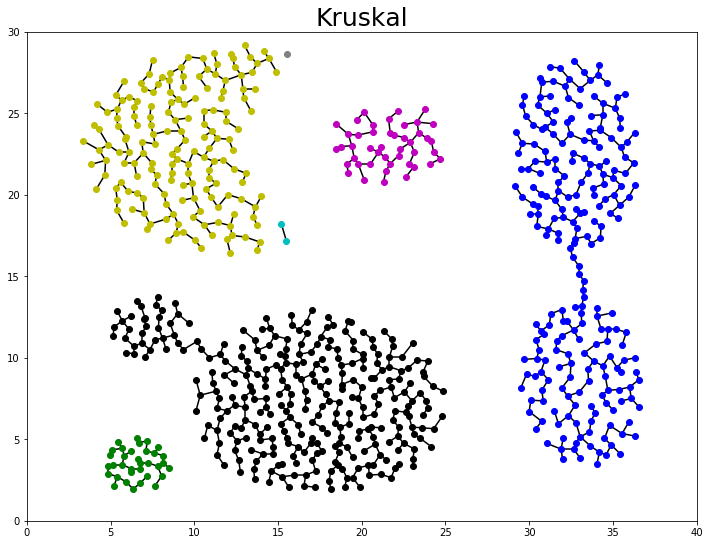

In [13]:
# Plot

plt.figure(figsize=(12,9))
plt.title('Kruskal', fontsize=25)
plt.axis([0, 40, 0, 30])
draw_edges(kk.tree, pv, 'k')
draw_points(pv,kk.part.relabeled())
plt.savefig('kruskal.png', bbox_inches='tight')

### Prim

In [14]:
#### Execute Prim
prim = Prim(adj)

In [15]:
#### Generate Prim Clustering

treev = np.array(prim.tree_edges, dtype=object) # numpy array for easer manipulation

small = treev[treev[:,0].argsort(0)][:-6] # remove 6 largest edges (let 7 connected components)
large = treev[treev[:,0].argsort(0)][-6:] # the 6 removed edges
smal_adj = edges_to_adj(small, npoints)   # adjacency list with only the relevant edges
prim_part = find_components(smal_adj)          # partition from the connected components

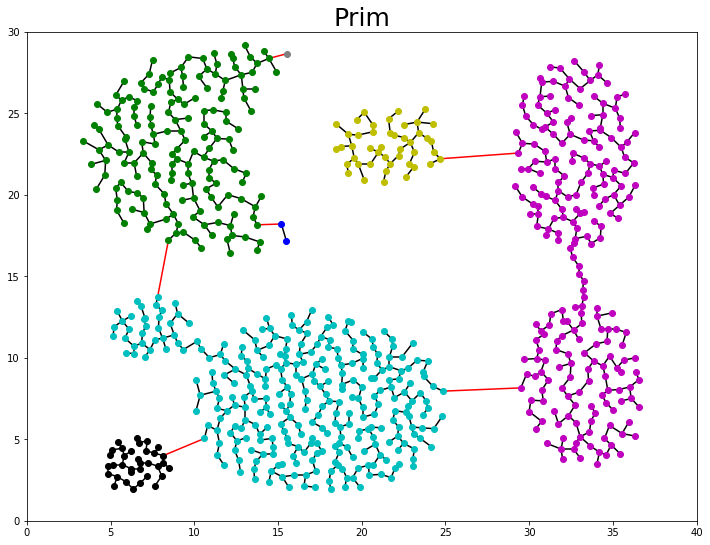

In [16]:
# Plot

plt.figure(figsize=(12,9))
plt.title("Prim", fontsize=25)
plt.axis([0, 40, 0, 30])
draw_edges(small, pv,'k')
draw_edges(large, pv, 'r')
draw_points(pv, prim_part)
plt.savefig('prim.png', bbox_inches='tight')

The rand score is a measure of similarity betwing different clusterings. It ranges from -1 to 1 but tends to give values close to 0 to random (uncorrelated) clusterings, 1 to identical clusrerings

In [17]:
metrics.adjusted_rand_score(np.round(np.random.random(100)*100), np.round(np.random.random(100)*100))

-0.010858935015006912

We can use ARS to check that, althoug the mappings obtained form Prim's and Kruskal algorithms are different, the clusterings are isomorphic

In [18]:
print(kk.part.relabeled() == prim_part) # mappings ar different
metrics.adjusted_rand_score(prim_part, list(kk.part)) # but isomorphic

False


1.0

And finally, the similarity between the MST clusterings and the reference clustering

In [19]:
reference = [int(line) for line in open("classes.txt")]
metrics.adjusted_rand_score(prim_part, reference)

0.8042069683967059